In [1]:
import importlib
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle

from ecpaper_utils import linfit_utils as linfit
from ecpaper_utils import bootstrap_utils as boot

importlib.reload(linfit)
importlib.reload(boot)

<module 'ecpaper_utils.bootstrap_utils' from '/home/islas/python/ecpaper2020/ecpaper_utils/bootstrap_utils.py'>

In [2]:
datapath="/project/cas/islas/python/ecpaper2020/DATASORT/VWIND/DATA/"
cmip5dat = datapath+"cmip5vwindindices.nc"
cmip6dat = datapath+"cmip6vwindindices.nc"
cmip5gmt = datapath+"globalmeantascmip5.nc"
cmip6gmt = datapath+"globalmeantascmip6.nc"
cmip5errors = "../ERRORCALC/VWIND/DATA/errors_cmip5.nc"
cmip6errors = "../ERRORCALC/VWIND/DATA/errors_cmip6.nc"
errors1mem = "../ERRORCALC/VWIND/DATA/errors_1mem.nc"

In [11]:
cmip5vwind = xr.open_dataset(cmip5dat) ; cmip6vwind = xr.open_dataset(cmip6dat)
gmt5 = xr.open_dataset(cmip5gmt) ; gmt6 = xr.open_dataset(cmip6gmt)
error5 = xr.open_dataset(cmip5errors) ; error6 = xr.open_dataset(cmip6errors) ; 
error1mem = xr.open_dataset(errors1mem)

CMIP5 variance decomposition and other calcs

In [27]:
# ensemble mean calculations for CMIP5

#delta V_SW after regressing out the change in global mean tas
a, b = linfit.linfit_xy( gmt5['tasemf'] - gmt5['tasemp'], cmip5vwind['vfutsw_em'] - cmip5vwind['vpastsw_em'], error5['sig_vdiff'])
vdiff_nots_em = (cmip5vwind['vfutsw_em'] - cmip5vwind['vpastsw_em']) - (a + b*(gmt5['tasemf']-gmt5['tasemp']))

# correlation between psi and delta VSW and uncertainty range
r5 = xr.corr( cmip5vwind['vpastamp_em'], cmip5vwind['vfutsw_em'] - cmip5vwind['vpastsw_em'])
minr5, maxr5 = boot.boot_corr_ci(cmip5vwind['vpastamp_em'], cmip5vwind['vfutsw_em'] - cmip5vwind['vpastsw_em'], 95)

# and after first regressing out global mean tas
r5nots = xr.corr( cmip5vwind['vpastamp_em'], vdiff_nots_em)
minr5nots, maxr5nots = boot.boot_corr_ci(cmip5vwind['vpastamp_em'], vdiff_nots_em, 95)

# variance of ensemble mean psi
varpsi5 = np.var(cmip5vwind['vpastamp_em'])
vardeltavsw5 = np.var( cmip5vwind['vfutsw_em'] - cmip5vwind['vpastsw_em'])

# ols regression coefficients and confidence interval
aols5em, bols5em = linfit.linfit_xy(cmip5vwind['vpastamp_em'], cmip5vwind['vfutsw_em'] - cmip5vwind['vpastsw_em'], error5['sig_vdiff'])
aolsrange5, bolsrange5, acoef, bcoef = boot.boot_regcoef_ci(cmip5vwind['vpastamp_em'], cmip5vwind['vfutsw_em'] - cmip5vwind['vpastsw_em'], 95,  sigy=error5['sig_vdiff'])

# tls regression coefficients and confidence interval
atls5em, btls5em = linfit.tls(cmip5vwind['vpastamp_em'], cmip5vwind['vfutsw_em'] - cmip5vwind['vpastsw_em'], error5['sig_psi'], error5['sig_vdiff'])
atlsrange5, btlsrange5, acoef, bcoef = boot.boot_regcoef_ci(cmip5vwind['vpastamp_em'], cmip5vwind['vfutsw_em'] - cmip5vwind['vpastsw_em'], 
                                                            95, sigx=error5['sig_psi'], sigy=error5['sig_vdiff'])

# bhm coefficients and confidence interval
abhmall5, bbhmall5, del2all5, muxall5, delx2all5 = linfit.bhm(cmip5vwind['vpastamp_em'], cmip5vwind['vfutsw_em']-cmip5vwind['vpastsw_em'],
                                                             error5['sig_psi'], error5['sig_vdiff'], error5['r_psi_vdiff'], iseed=3)

abhm5em = np.mean(abhmall5)
bbhm5em = np.mean(bbhmall5)
abhmmin = np.percentile(abhmall5,2.5) ; abhmmax = np.percentile(abhmall5,97.5)
bbhmmin = np.percentile(bbhmall5,2.5) ; bbhmmax = np.percentile(bbhmall5,97.5)
abhmrange5=[abhmmin,abhmmax]
bbhmrange5=[bbhmmin,bbhmmax]

In [13]:
# single member calculations for CMIP5

# expand 1 member error estimates to array of size nmodels
sigx1mem = np.repeat(np.array(error1mem['sig_psi']), cmip5vwind['vpastamp_em'].size)
sigy1mem = np.repeat(np.array(error1mem['sig_vdiff']), cmip5vwind['vpastamp_em'].size)
rxy1mem = np.repeat(np.array(error1mem['r_psi_vdiff']), cmip5vwind['vpastamp_em'].size)

# regress out global mean tas change from jet shift
a, b = linfit.linfit_xy(gmt5['tas1memf'] - gmt5['tas1memp'], cmip5vwind['vfutsw_1mem'] - cmip5vwind['vpastsw_1mem'], sigy1mem)
vdiff_nots = (cmip5vwind['vfutsw_1mem']-cmip5vwind['vpastsw_1mem']) - (a + b*(gmt5['tas1memf'] - gmt5['tas1memp']))
var_nots = np.var(vdiff_nots)

# single member variance
var5 = np.var(cmip5vwind['vfutsw_1mem'] - cmip5vwind['vpastsw_1mem'])

# single member variance explained by global mean tas change
vartsexplain5 = var5 - var_nots

# ols regression variance decomposition
aols5, bols5 = linfit.linfit_xy(cmip5vwind['vpastamp_1mem'], cmip5vwind['vfutsw_1mem'] - cmip5vwind['vpastsw_1mem'], sigy1mem)
vdiff_ec = aols5 + bols5*cmip5vwind['vpastamp_1mem']
res = (cmip5vwind['vfutsw_1mem'] - cmip5vwind['vpastsw_1mem']) - vdiff_ec[:]

varres5_ols = np.var(res)
var5ec_ols = var5 - varres5_ols
variv5_ols = (bols5**2. * sigx1mem[0]**2.) + sigy1mem[0]**2.
vardelta5_ols = var5 - (var5ec_ols + variv5_ols)

cmip5olsdecomp = [var5ec_ols, variv5_ols, vardelta5_ols]

# tls regression variance decomposition
atls5, btls5 = linfit.tls(cmip5vwind['vpastamp_1mem'], cmip5vwind['vfutsw_1mem'] - cmip5vwind['vpastsw_1mem'], sigx1mem, sigy1mem)
vdiff_ec = atls5 + btls5*cmip5vwind['vpastamp_1mem']
res = (cmip5vwind['vfutsw_1mem'] - cmip5vwind['vpastsw_1mem']) - vdiff_ec[:]

varres5_tls = np.var(res)
var5ec_tls = var5 - varres5_tls
variv5_tls = (btls5**2. * sigx1mem[0]**2.) + sigy1mem[0]**2.
vardelta5_tls = var5 - (var5ec_tls + variv5_tls)

cmip5tlsdecomp=[var5ec_tls, variv5_tls, vardelta5_tls]


# bhm variance decomposition
abhmall5, bbhmall5, del2all5, muxall5, delx2all5 = linfit.bhm(cmip5vwind['vpastamp_1mem'], (cmip5vwind['vfutsw_1mem']-cmip5vwind['vpastsw_1mem']),
                                                             sigx1mem, sigy1mem, rxy1mem, iseed=3)

abhm5 = np.mean(abhmall5) ; bbhm5 = np.mean(bbhmall5)
varec=delx2all5[:]*bbhmall5[:]**2.
vardel=del2all5[:]
variv=sigy1mem[0]*(1-rxy1mem[0]**2.)

var5ec_bhm = np.mean( varec[:]/(varec[:] + vardel[:] + variv))
vardelta5_bhm = np.mean( vardel[:]/(varec[:] + vardel[:] + variv))
variv5_bhm = np.mean( variv/(varec[:] + vardel[:] + variv))

cmip5bhmdecomp=[var5ec_bhm, variv5_bhm, vardelta5_bhm]

In [14]:
# ensemble mean calculations for CMIP6

#delta V_SW after regressing out the change in global mean tas
a, b = linfit.linfit_xy( gmt6['tasemf'] - gmt6['tasemp'], cmip6vwind['vfutsw_em'] - cmip6vwind['vpastsw_em'], error6['sig_vdiff'])
vdiff_nots_em = (cmip6vwind['vfutsw_em'] - cmip6vwind['vpastsw_em']) - (a + b*(gmt6['tasemf']-gmt6['tasemp']))

# correlation between psi and delta VSW and uncertainty range
r6 = xr.corr( cmip6vwind['vpastamp_em'], cmip6vwind['vfutsw_em'] - cmip6vwind['vpastsw_em'])
minr6, maxr6 = boot.boot_corr_ci(cmip6vwind['vpastamp_em'], cmip6vwind['vfutsw_em'] - cmip6vwind['vpastsw_em'], 95)

# and after first regressing out global mean tas
r6nots = xr.corr( cmip6vwind['vpastamp_em'], vdiff_nots_em)
minr6nots, maxr6nots = boot.boot_corr_ci(cmip6vwind['vpastamp_em'], vdiff_nots_em, 95)

# variance of ensemble mean psi
varpsi6 = np.var(cmip6vwind['vpastamp_em'])
vardeltavsw6 = np.var( cmip6vwind['vfutsw_em'] - cmip6vwind['vpastsw_em'])

# ols regression coefficients and confidence interval
aols6em, bols6em = linfit.linfit_xy(cmip6vwind['vpastamp_em'], cmip6vwind['vfutsw_em'] - cmip6vwind['vpastsw_em'], error6['sig_vdiff'])
aolsrange6, bolsrange6, acoef, bcoef = boot.boot_regcoef_ci(cmip6vwind['vpastamp_em'], cmip6vwind['vfutsw_em'] - cmip6vwind['vpastsw_em'], 95,  sigy=error6['sig_vdiff'])

# tls regression coefficients and confidence interval
atls6em, btls6em = linfit.tls(cmip6vwind['vpastamp_em'], cmip6vwind['vfutsw_em'] - cmip6vwind['vpastsw_em'], error6['sig_psi'], error6['sig_vdiff'])
atlsrange6, btlsrange6, acoef, bcoef = boot.boot_regcoef_ci(cmip6vwind['vpastamp_em'], cmip6vwind['vfutsw_em'] - cmip6vwind['vpastsw_em'], 
                                                            95, sigx=error6['sig_psi'], sigy=error6['sig_vdiff'])

# bhm coefficients and confidence interval
abhmall6, bbhmall6, del2all6, muxall6, delx2all6 = linfit.bhm(cmip6vwind['vpastamp_em'], cmip6vwind['vfutsw_em']-cmip6vwind['vpastsw_em'],
                                                             error6['sig_psi'], error6['sig_vdiff'], error6['r_psi_vdiff'], iseed=3)

abhm6em = np.mean(abhmall6)
bbhm6em = np.mean(bbhmall6)
abhmmin = np.percentile(abhmall6,2.5) ; abhmmax = np.percentile(abhmall6,97.5)
bbhmmin = np.percentile(bbhmall6,2.5) ; bbhmmax = np.percentile(bbhmall6,97.5)
abhmrange6=[abhmmin,abhmmax]
bbhmrange6=[bbhmmin,bbhmmax]

In [15]:
# single member calculations for CMIP6

# expand 1 member error estimates to array of size nmodels
sigx1mem = np.repeat(np.array(error1mem['sig_psi']), cmip6vwind['vpastamp_em'].size)
sigy1mem = np.repeat(np.array(error1mem['sig_vdiff']), cmip6vwind['vpastamp_em'].size)
rxy1mem = np.repeat(np.array(error1mem['r_psi_vdiff']), cmip6vwind['vpastamp_em'].size)

# regress out global mean tas change from jet shift
a, b = linfit.linfit_xy(gmt6['tas1memf'] - gmt6['tas1memp'], cmip6vwind['vfutsw_1mem'] - cmip6vwind['vpastsw_1mem'], sigy1mem)
vdiff_nots = (cmip6vwind['vfutsw_1mem']-cmip6vwind['vpastsw_1mem']) - (a + b*(gmt6['tas1memf'] - gmt6['tas1memp']))
var_nots = np.var(vdiff_nots)

# single member variance
var6 = np.var(cmip6vwind['vfutsw_1mem'] - cmip6vwind['vpastsw_1mem'])

# single member variance explained by global mean tas change
vartsexplain6 = var6 - var_nots

# ols regression variance decomposition
aols6, bols6 = linfit.linfit_xy(cmip6vwind['vpastamp_1mem'], cmip6vwind['vfutsw_1mem'] - cmip6vwind['vpastsw_1mem'], sigy1mem)
vdiff_ec = aols6 + bols6*cmip6vwind['vpastamp_1mem']
res = (cmip6vwind['vfutsw_1mem'] - cmip6vwind['vpastsw_1mem']) - vdiff_ec[:]

varres6_ols = np.var(res)
var6ec_ols = var6 - varres6_ols
variv6_ols = (bols6**2. * sigx1mem[0]**2.) + sigy1mem[0]**2.
vardelta6_ols = var6 - (var6ec_ols + variv6_ols)

cmip6olsdecomp = [var6ec_ols, variv6_ols, vardelta6_ols]

# tls regression variance decomposition
atls6, btls6 = linfit.tls(cmip6vwind['vpastamp_1mem'], cmip6vwind['vfutsw_1mem'] - cmip6vwind['vpastsw_1mem'], sigx1mem, sigy1mem)
vdiff_ec = atls6 + btls6*cmip6vwind['vpastamp_1mem']
res = (cmip6vwind['vfutsw_1mem'] - cmip6vwind['vpastsw_1mem']) - vdiff_ec[:]

varres6_tls = np.var(res)
var6ec_tls = var6 - varres6_tls
variv6_tls = (btls6**2. * sigx1mem[0]**2.) + sigy1mem[0]**2.
vardelta6_tls = var6 - (var6ec_tls + variv6_tls)

cmip6tlsdecomp=[var6ec_tls, variv6_tls, vardelta6_tls]


# bhm variance decomposition
abhmall6, bbhmall6, del2all6, muxall6, delx2all6 = linfit.bhm(cmip6vwind['vpastamp_1mem'], (cmip6vwind['vfutsw_1mem']-cmip6vwind['vpastsw_1mem']),
                                                             sigx1mem, sigy1mem, rxy1mem, iseed=3)

abhm6 = np.mean(abhmall6) ; bbhm6 = np.mean(bbhmall6)
varec=delx2all6[:]*bbhmall6[:]**2.
vardel=del2all6[:]
variv=sigy1mem[0]*(1-rxy1mem[0]**2.)

var6ec_bhm = np.mean( varec[:]/(varec[:] + vardel[:] + variv))
vardelta6_bhm = np.mean( vardel[:]/(varec[:] + vardel[:] + variv))
variv6_bhm = np.mean( variv/(varec[:] + vardel[:] + variv))

cmip6bhmdecomp=[var6ec_bhm, variv6_bhm, vardelta6_bhm]

Text(4.5, 0.06, 'influence')

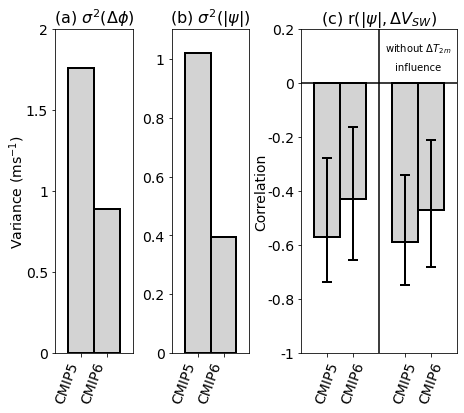

In [46]:
fig = plt.figure()
w = 18 ; h = 5
fig.set_size_inches(w, h)

# variance in delta V_SW
ax1 = fig.add_axes(np.array([0.05,0.05,0.06,0.9]))
ax1.set_xlim(0,3)
ax1.set_xticks([1,2])
ax1.set_ylim(0,2.)
ax1.set_yticks([0,0.5,1,1.5,2])
ax1.set_yticklabels(['0','0.5','1','1.5','2'], fontsize=14)
ax1.set_ylabel('Variance (ms$^{-1}$)', fontsize=14, labelpad=-1)
ax1.set_xticklabels(['CMIP5', 'CMIP6'], fontsize=14, rotation=70, ha='right')
ax1.set_title("(a) $\sigma^{2}(\Delta \phi)$", fontsize=16)
ax1.bar(1, vardeltavsw5, width=1, bottom=None, align='center', color='lightgray', edgecolor='black', linewidth=2)
ax1.bar(2, vardeltavsw6, width=1, bottom=None, align='center', color='lightgray', edgecolor='black', linewidth=2)

ax2 = fig.add_axes(np.array([0.14,0.05,0.06,0.9]))
ax2.set_xlim(0,3)
ax2.set_ylim(0,1.1)
ax2.set_xticks([1,2])
ax2.set_xticklabels(['CMIP5','CMIP6'], rotation=70, fontsize=14, ha='right')
ax2.set_yticks([0,0.2,0.4,0.6,0.8,1])
ax2.set_yticklabels(['0','0.2','0.4','0.6','0.8','1'], fontsize=14)
ax2.set_title("(b) $\sigma^{2}(|\psi|)$", fontsize=16)
ax2.bar(1, varpsi5, width=1, bottom=None, align='center', color='lightgray', edgecolor='black', linewidth=2)
ax2.bar(2, varpsi6, width=1, bottom=None, align='center', color='lightgray', edgecolor='black', linewidth=2)

ax3 = fig.add_axes(np.array([0.24,0.05,0.12,0.9]))
ax3.set_xlim(0,6)
ax3.set_xticks([1, 2, 4, 5])
ax3.set_xticklabels(['CMIP5','CMIP6','CMIP5','CMIP6'], rotation=70, fontsize=14)
ax3.set_yticks([-1,-0.8,-0.6,-0.4,-0.2,0,0.2])
ax3.set_yticklabels(['-1','-0.8','-0.6','-0.4','-0.2','0','0.2'], fontsize=14)
ax3.set_ylabel('Correlation', fontsize=14, labelpad=-1)
ax3.set_title('(c) r($|\psi|, \Delta V_{SW}$)', fontsize=16)
ax3.set_ylim(-1,0.2)
ax3.set_xlim(0,6)

# CMIP5 correlation
ax3.bar(1,r5,width=1,bottom=0,align='center',color='lightgray',edgecolor='black',linewidth=2)
ax3.errorbar(1,r5,[[r5-minr5],[maxr5-r5]], color='black', linewidth=2, capsize=5, capthick=2.)

# CMIP6 correlation
ax3.bar(2,r6,width=1,bottom=0,align='center',color='lightgray',edgecolor='black',linewidth=2)
ax3.errorbar(2,r6,[[r6-minr6],[maxr6-r6]], color='black', linewidth=2, capsize=5, capthick=2.)

# CMIP5 correlation after regressing out tas
ax3.bar(4, r5nots, width=1, bottom=0, align='center', color='lightgray', edgecolor='black', linewidth=2)
ax3.errorbar(4, r5nots, [[r5nots-minr5nots], [maxr5nots-r5nots]], color='black', linewidth=2, capsize=5, capthick=2)

# CMIP6 correlation after regressing out tas
ax3.bar(5, r6nots, width=1, bottom=0, align='center', color='lightgray', edgecolor='black', linewidth=2)
ax3.errorbar(5, r6nots, [[r6nots-minr6nots], [maxr6nots-r6nots]], color='black', linewidth=2, capsize=5, capthick=2)

ax3.plot([0,6],[0,0], color='black')
ax3.plot([3,3],[-1,0.2], color='black')
ax3.text(4.5, 0.13,'without $\Delta T_{2m}$', horizontalalignment='center',verticalalignment='center',fontsize=10,color='black')
ax3.text(4.5, 0.06,'influence',horizontalalignment='center',verticalalignment='center',fontsize=10,color='black')

In [47]:
# -------variance decomposition (%) panel b ----------------
ax4 = fig.add_axes(np.array([0.4,0.05,0.12,0.9]))
# -------------Variance decomposition, panel a -------------------
ax4.set_xticks([2.,3.,4.,7.,8.,9.])
ax4.set_xticklabels(['OLS','TLS','BHM','OLS','TLS','BHM'], rotation='70', fontsize=14)
ax4.set_yticks([0,20,40,60,80,100])
ax4.set_yticklabels(['0','20','40','60','80','100'], fontsize=14)
ax4.set_ylabel("Variance (%)", fontsize=14, labelpad=-1)
ax4.set_title("(d) % variance in $\Delta \phi$", fontsize=16)

ax4.bar(1., (var5/var5)*100., width=1, bottom=None, align='center', color='lightgray', edgecolor='black', linewidth=2)
ax4.bar(1., (vartsexplain5/var5)*100., width=1, bottom=None, align='center', fill=False, linewidth=0, hatch='////')

decompcolors=["darkred","seagreen","cornflowerblue"]
varpartname=['ec','iv','delta']

bot=0
for i in range(0,3):
    ax4.bar(2., (cmip5olsdecomp[i]/var5)*100., width=1, bottom=bot, align='center', color=decompcolors[i], edgecolor='black', linewidth=2)
    bot=bot+(cmip5olsdecomp[i]/var5)*100.
    print(varpartname[i]+' '+str((cmip5olsdecomp[i]/var5)*100.))
    
bot=0
for i in range(0,3):
    ax4.bar(3., (cmip5tlsdecomp[i]/var5)*100., width=1, bottom=bot, align='center', color=decompcolors[i], edgecolor='black', linewidth=2)
    bot=bot+(cmip5tlsdecomp[i]/var5)*100.
    print(varpartname[i]+' '+str((cmip5tlsdecomp[i]/var5)*100.))
    
bot=0
for i in range(0,3):
    ax4.bar(4., (cmip5bhmdecomp[i]/np.sum(cmip5bhmdecomp))*100., width=1, bottom=bot, align='center', color=decompcolors[i], edgecolor='black', linewidth=2)
    bot=bot+(cmip5bhmdecomp[i]/np.sum(cmip5bhmdecomp))*100.   
    print(varpartname[i]+' '+str((cmip5bhmdecomp[i]/var5)*100.))
          
ax4.bar(6, (var6/var6)*100., width=1, bottom=None, align='center', color='lightgray', edgecolor='black', linewidth=2)
ax4.bar(6, (vartsexplain6/var6)*100., width=1, bottom=None, align='center', fill=False, linewidth=0, hatch='////')

bot=0
for i in range(0,3):
    ax4.bar(7., (cmip6olsdecomp[i]/var6)*100., width=1, bottom=bot, align='center', color=decompcolors[i], edgecolor='black', linewidth=2)
    bot=bot+(cmip6olsdecomp[i]/var6)*100.
    
bot=0
for i in range(0,3):
    ax4.bar(8., (cmip6tlsdecomp[i]/var6)*100., width=1, bottom=bot, align='center', color=decompcolors[i], edgecolor='black', linewidth=2)
    bot=bot+(cmip6tlsdecomp[i]/var6)*100.  
    
bot=0
for i in range(0,3):
    ax4.bar(9., (cmip6bhmdecomp[i]/np.sum(cmip6bhmdecomp))*100., width=1, bottom=bot, align='center', color=decompcolors[i], edgecolor='black', linewidth=2)
    bot=bot+(cmip6bhmdecomp[i]/np.sum(cmip6bhmdecomp))*100.  

ec <xarray.DataArray ()>
array(29.24517729)
iv <xarray.DataArray ()>
array(33.61898958)
delta <xarray.DataArray ()>
array(37.13583313)
ec <xarray.DataArray ()>
array(28.569502)
iv <xarray.DataArray ()>
array(34.22373366)
delta <xarray.DataArray ()>
array(37.20676433)
ec <xarray.DataArray ()>
array(17.03146463)
iv <xarray.DataArray ()>
array(18.97510391)
delta <xarray.DataArray ()>
array(19.12174338)


In [48]:
legendparts=[Rectangle((0.95,0.95),5,3,facecolor='lightgray', edgecolor='black'),
             Rectangle((0.95,0.95),5,3,linewidth=0,fill='None', facecolor='white', hatch='////'),
             Rectangle((0.95,0.95),5,3,facecolor='darkred',edgecolor='black'),
             Rectangle((0.95,0.95),5,3,facecolor='seagreen',edgecolor='black'),
             Rectangle((0.95,0.95),5,3,facecolor='cornflowerblue',edgecolor='black')]
legendlabels=['$\sigma^{2}(\Delta \phi)$','$\sigma^{2}_{\Delta T_{2m}}$','$\sigma^{2}_{EC}$','$\sigma^{2}_{IV}$','$\sigma^{2}_{\delta}$']
fig.legend(legendparts, legendlabels, bbox_to_anchor = (0.59,0.75), ncol=1, frameon=False, fontsize='x-large', handlelength=1, handleheight=1, handletextpad=0.4)

In [49]:
ax5 = fig.add_axes(np.array([0.625,0.55,0.25,0.4]))
ax5.set_xlim(0,8)
ax5.set_ylim(-3,6)
ax5.set_yticks([-2,0,2,4,6])
ax5.set_yticklabels(['-2','0','2','4','6'], fontsize=14)
ax5.set_xticks([])
ax5.plot([0,9],[0,0],color='black')
ax5.plot([4,4],[-34,10],color='black')
ax5.set_ylabel('$\\alpha$ ($\circ$ N)', fontsize=14)
ax5.set_title('(e) $\\alpha$ parameter', fontsize=16)

ax5.bar(1,aols5em,bottom=0,width=1,color='saddlebrown', linewidth=2, edgecolor='black')
ax5.errorbar(1,aols5em,[[aols5em-aolsrange5[0]],[aolsrange5[1]-aols5em]], color='black', linewidth=2, capsize=5, capthick=2.)

ax5.bar(2,atls5em,bottom=0,width=1,color='forestgreen',linewidth=2,edgecolor='black')
ax5.errorbar(2,atls5em,[[atls5em-atlsrange5[0]],[atlsrange5[1]-atls5em]], color='black', linewidth=2, capsize=5, capthick=2.)

ax5.bar(3,abhm5em,bottom=0,width=1,color='blueviolet',linewidth=2,edgecolor='black')
ax5.errorbar(3,abhm5em,[[abhm5em-abhmrange5[0]],[abhmrange5[1]-abhm5em]], color='black', linewidth=2, capsize=5, capthick=2.)

ax5.bar(5,aols6em,bottom=0,width=1,color='saddlebrown',linewidth=2,edgecolor='black')
ax5.errorbar(5,aols6em,[[aols6em-aolsrange6[0]],[aolsrange6[1]-aols6em]], color='black', linewidth=2, capsize=5, capthick=2.)
ax5.bar(6,atls6em,bottom=0,width=1,color='forestgreen',linewidth=2,edgecolor='black')
ax5.errorbar(6,atls6em,[[atls6em-atlsrange6[0]],[atlsrange6[1]-atls6em]], color='black', linewidth=2, capsize=5, capthick=2.)
ax5.bar(7,abhm6em,bottom=0,width=1,color='blueviolet',linewidth=2,edgecolor='black')
ax5.errorbar(7,abhm6em,[[abhm6em-abhmrange6[0]],[abhmrange6[1]-abhm6em]], color='black', linewidth=2, capsize=5, capthick=2.)

ax5.text(2, 5, 'CMIP5', horizontalalignment='center', verticalalignment='center', fontsize=16)
ax5.text(6, 5, 'CMIP6', horizontalalignment='center', verticalalignment='center', fontsize=16)

Text(6, 5, 'CMIP6')

In [50]:
ax6 = fig.add_axes(np.array([0.625,0.05,0.25,0.4]))
ax6.set_xlim(0,8)
ax6.set_ylim(-2,1)
ax6.set_yticks([-2,-1.5,-1,-0.5,0,0.5,1])
ax6.set_yticklabels(['-2','-1.5','-1','-0.5','0','0.5','1'], fontsize=14)
ax6.set_xticks([])
ax6.plot([0,9],[0,0],color='black')
ax6.plot([4,4],[-2,1],color='black')
ax6.set_ylabel('$\\beta$', fontsize=14)
ax6.set_title('(f) $\\beta$ parameter', fontsize=16)

ax6.bar(1,bols5em,bottom=0,width=1,color='saddlebrown', linewidth=2, edgecolor='black')
ax6.errorbar(1,bols5em,[[bols5em-bolsrange5[0]],[bolsrange5[1]-bols5em]], color='black', linewidth=2, capsize=5, capthick=2.)

ax6.bar(2,btls5em,bottom=0,width=1,color='forestgreen',linewidth=2,edgecolor='black')
ax6.errorbar(2,btls5em,[[btls5em-btlsrange5[0]],[btlsrange5[1]-btls5em]], color='black', linewidth=2, capsize=5, capthick=2.)

ax6.bar(3,bbhm5em,bottom=0,width=1,color='blueviolet',linewidth=2,edgecolor='black')
ax6.errorbar(3,bbhm5em,[[bbhm5em-bbhmrange5[0]],[bbhmrange5[1]-bbhm5em]], color='black', linewidth=2, capsize=5, capthick=2.)

ax6.bar(5,bols6em,bottom=0,width=1,color='saddlebrown',linewidth=2,edgecolor='black')
ax6.errorbar(5,bols6em,[[bols6em-bolsrange6[0]],[bolsrange6[1]-bols6em]], color='black', linewidth=2, capsize=5, capthick=2.)
ax6.bar(6,btls6em,bottom=0,width=1,color='forestgreen',linewidth=2,edgecolor='black')
ax6.errorbar(6,btls6em,[[btls6em-btlsrange6[0]],[btlsrange6[1]-btls6em]], color='black', linewidth=2, capsize=5, capthick=2.)
ax6.bar(7,bbhm6em,bottom=0,width=1,color='blueviolet',linewidth=2,edgecolor='black')
ax6.errorbar(7,bbhm6em,[[bbhm6em-bbhmrange6[0]],[bbhmrange6[1]-bbhm6em]], color='black', linewidth=2, capsize=5, capthick=2.)

ax6.text(2, 0.5, 'CMIP5', horizontalalignment='center', verticalalignment='center', fontsize=16)
ax6.text(6, 0.5, 'CMIP6', horizontalalignment='center', verticalalignment='center', fontsize=16)

Text(6, 0.5, 'CMIP6')

In [51]:
legendparts=[Rectangle((0.95,0.95),5,3,facecolor='saddlebrown', edgecolor='black'),
             Rectangle((0.95,0.95),5,3,facecolor='forestgreen', edgecolor='black'),
             Rectangle((0.95,0.95),5,3,facecolor='blueviolet',edgecolor='black')]
legendlabels=['OLS','TLS','BHM']
fig.legend(legendparts, legendlabels, bbox_to_anchor = (0.73,0.01), ncol=3, frameon=False, fontsize='x-large', handlelength=1, handleheight=1, handletextpad=0.4, loc='center')

In [52]:
#plot the plot
fig.patch.set_facecolor('white')
fig
fig.savefig('fig8.png', facecolor='white', bbox_inches='tight')